#### Fork process creation method

Include the analysis script and setup the folders with raw data

In [1]:
from benchmarking.analysis.analyze_results import *

In [2]:
output_base_folder = Path("/iarai/home/ivan.svogor/storage-benchmarking-raw/referenced-experiments")
s3_folder_filter="1711-fork/s3/*benchmark_e2e*"
scratch_folder_filter="1711-fork/scratch/*benchmark_e2e*"

#### Load raw data

In [3]:
df_dataloader_s3 = extract_timelines(output_base_folder, folder_filter=s3_folder_filter)
df_dataloader_scratch = extract_timelines(output_base_folder, folder_filter=scratch_folder_filter)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 158.25it/s]


In [4]:
df_gpuutil_s3 = extract_gpuutil(output_base_folder, folder_filter=s3_folder_filter)
df_gpuutil_scratch = extract_gpuutil(output_base_folder, folder_filter=scratch_folder_filter)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 3762.61it/s]


#### Timeline plots

Each line corresponds to a unique function call.

timestamp False


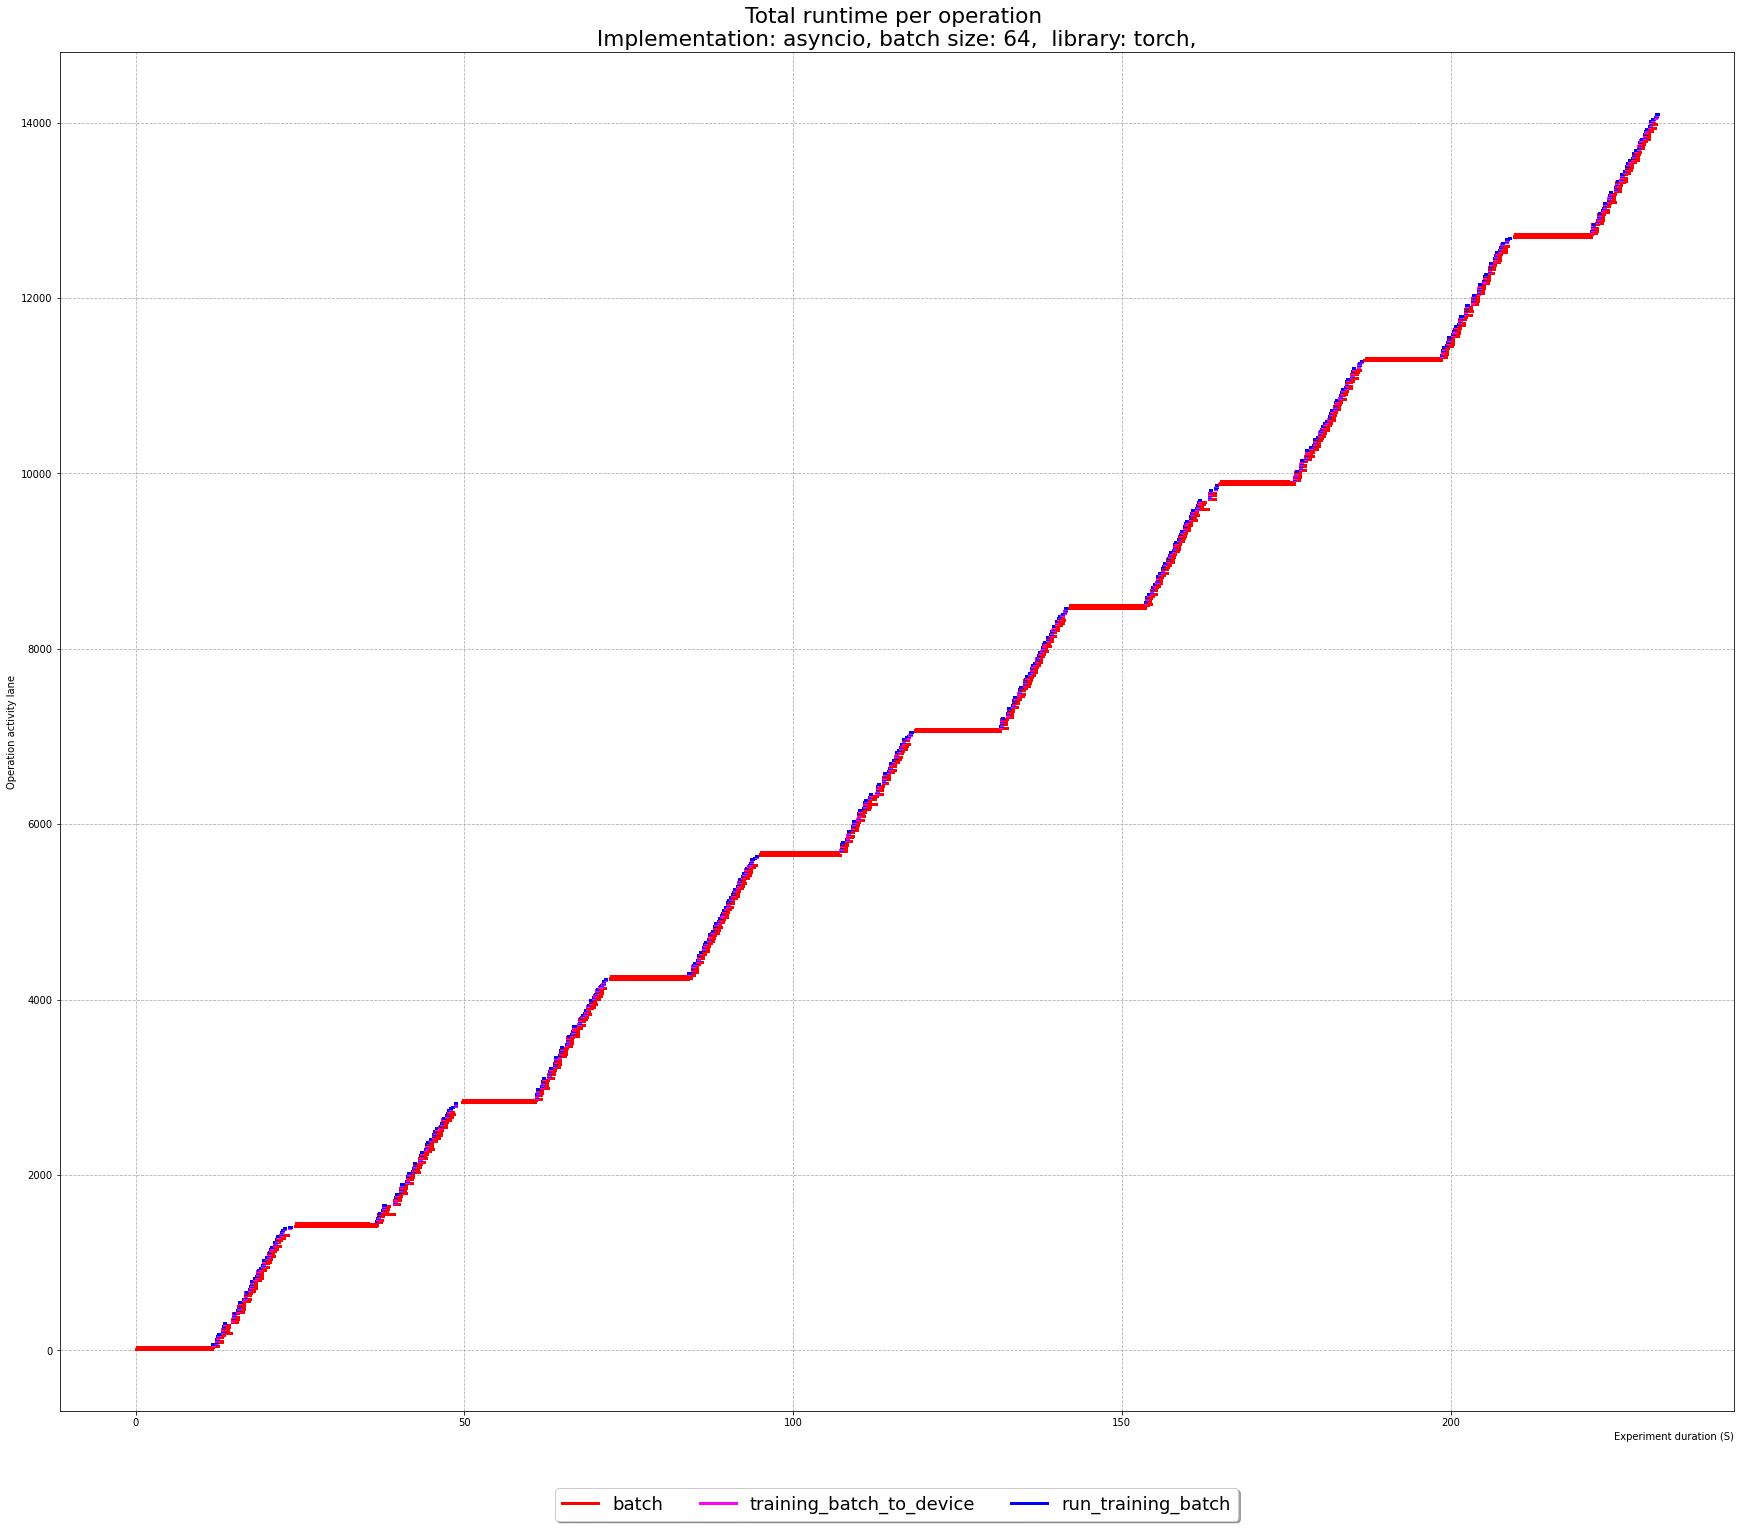

timestamp False


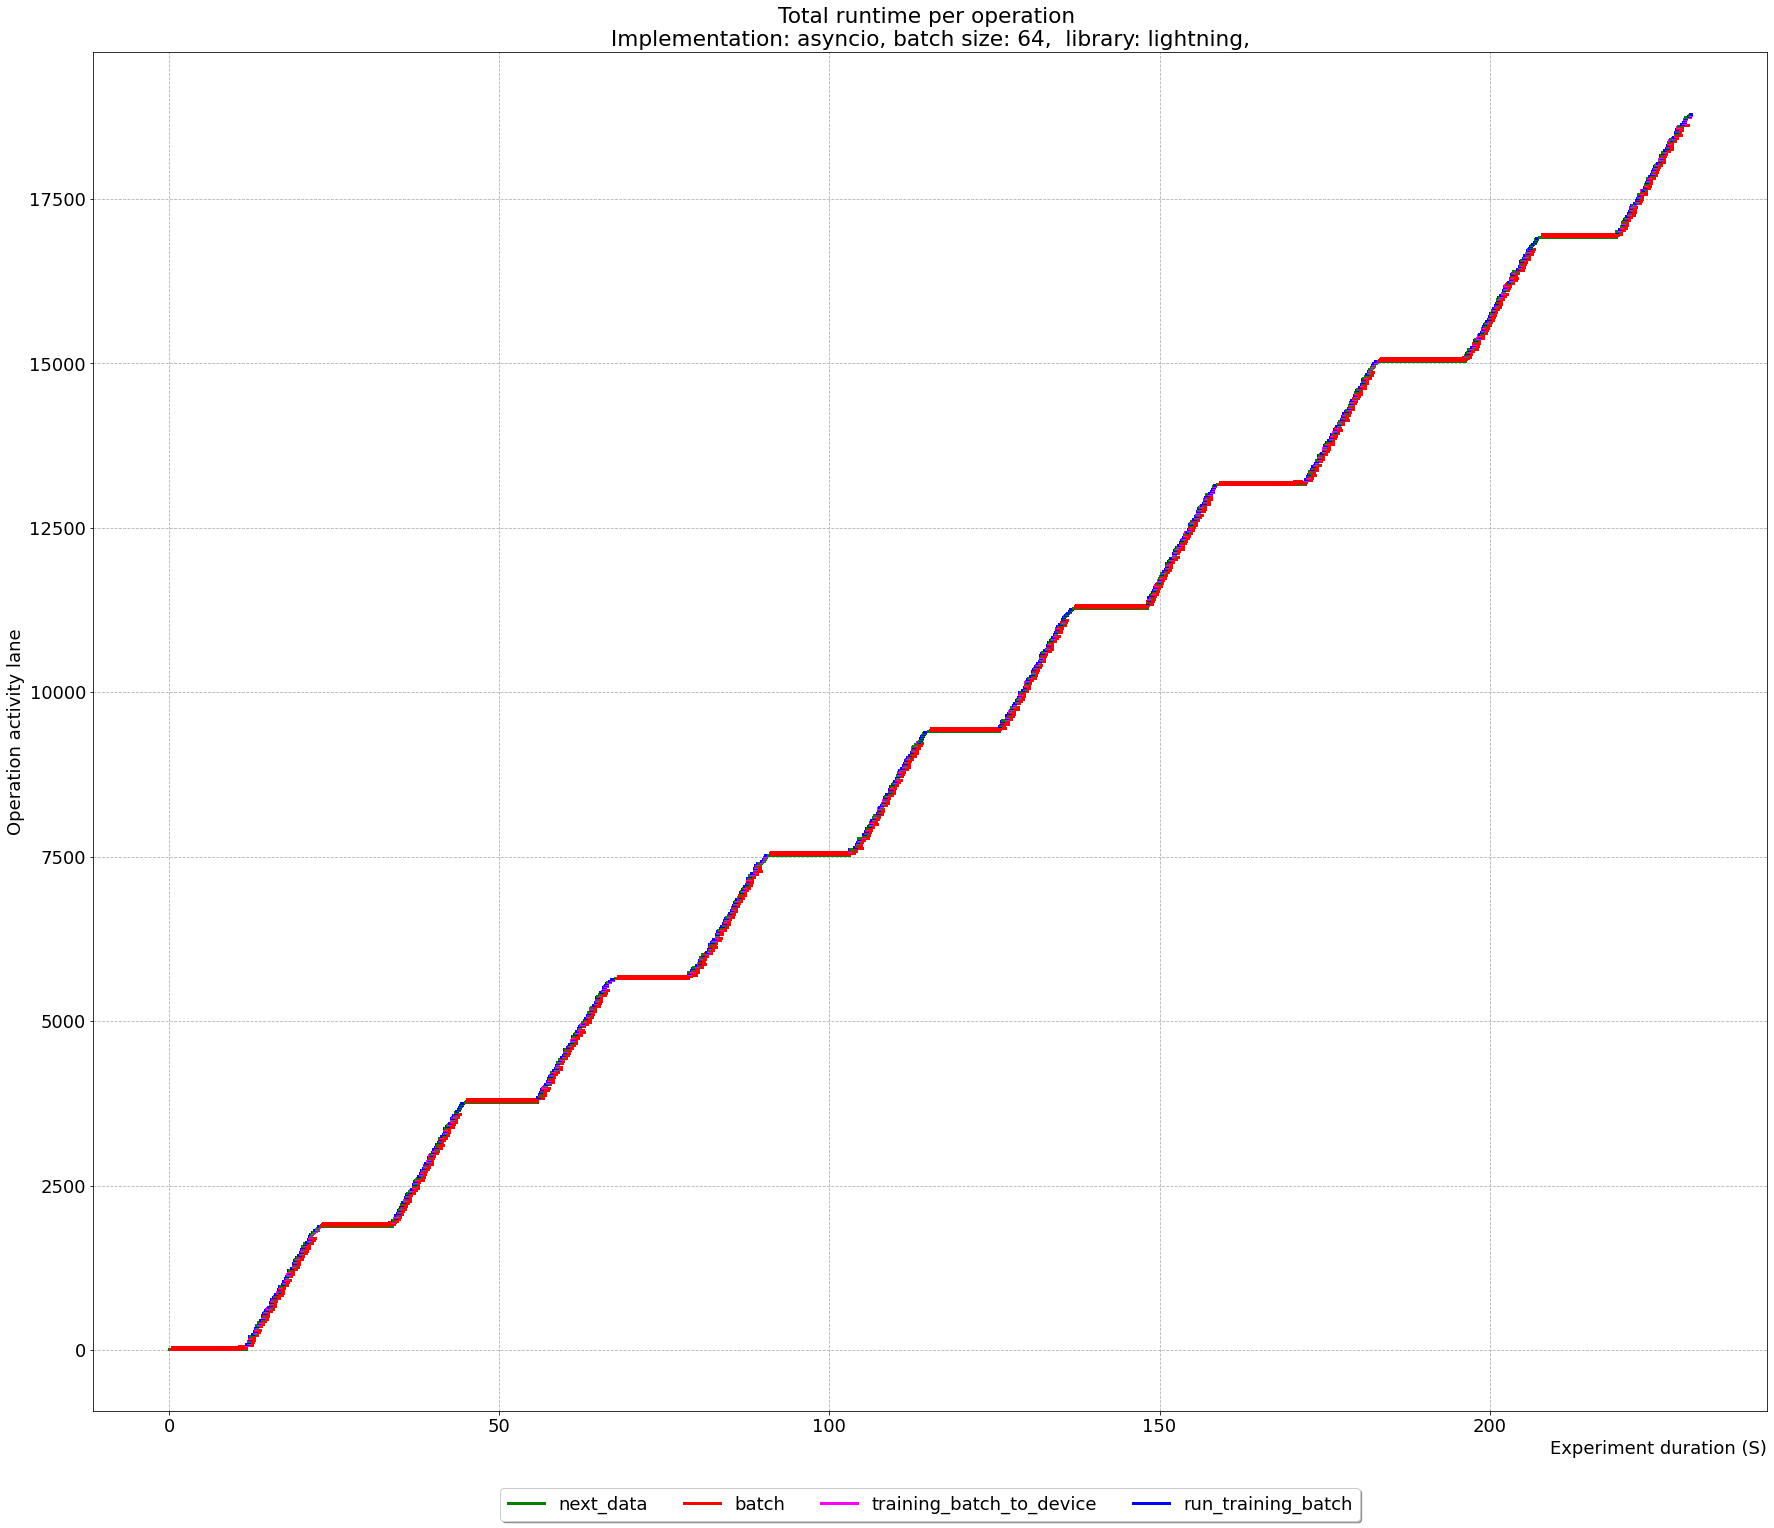

In [5]:
unique_runs_s3, unique_functions, colors, lanes = get_colors_runs_and_lanes(df_dataloader_s3)
returns_s3 = []

for implementation in ["torch", "lightning"]:
    for run in sorted(unique_runs_s3):
        if implementation in run:
            df = df_dataloader_s3[df_dataloader_s3["run"]==run]
            dfgpu = df_gpuutil_s3[df_gpuutil_s3["run"]==run]
            df = df.drop_duplicates(subset="id", keep="first", inplace=False) 
            result = show_timelines_with_gpu(df, dfgpu, lanes, colors, run, False, False, False, 2)
            result["run"]=run
            returns_s3.append(result)

timestamp False


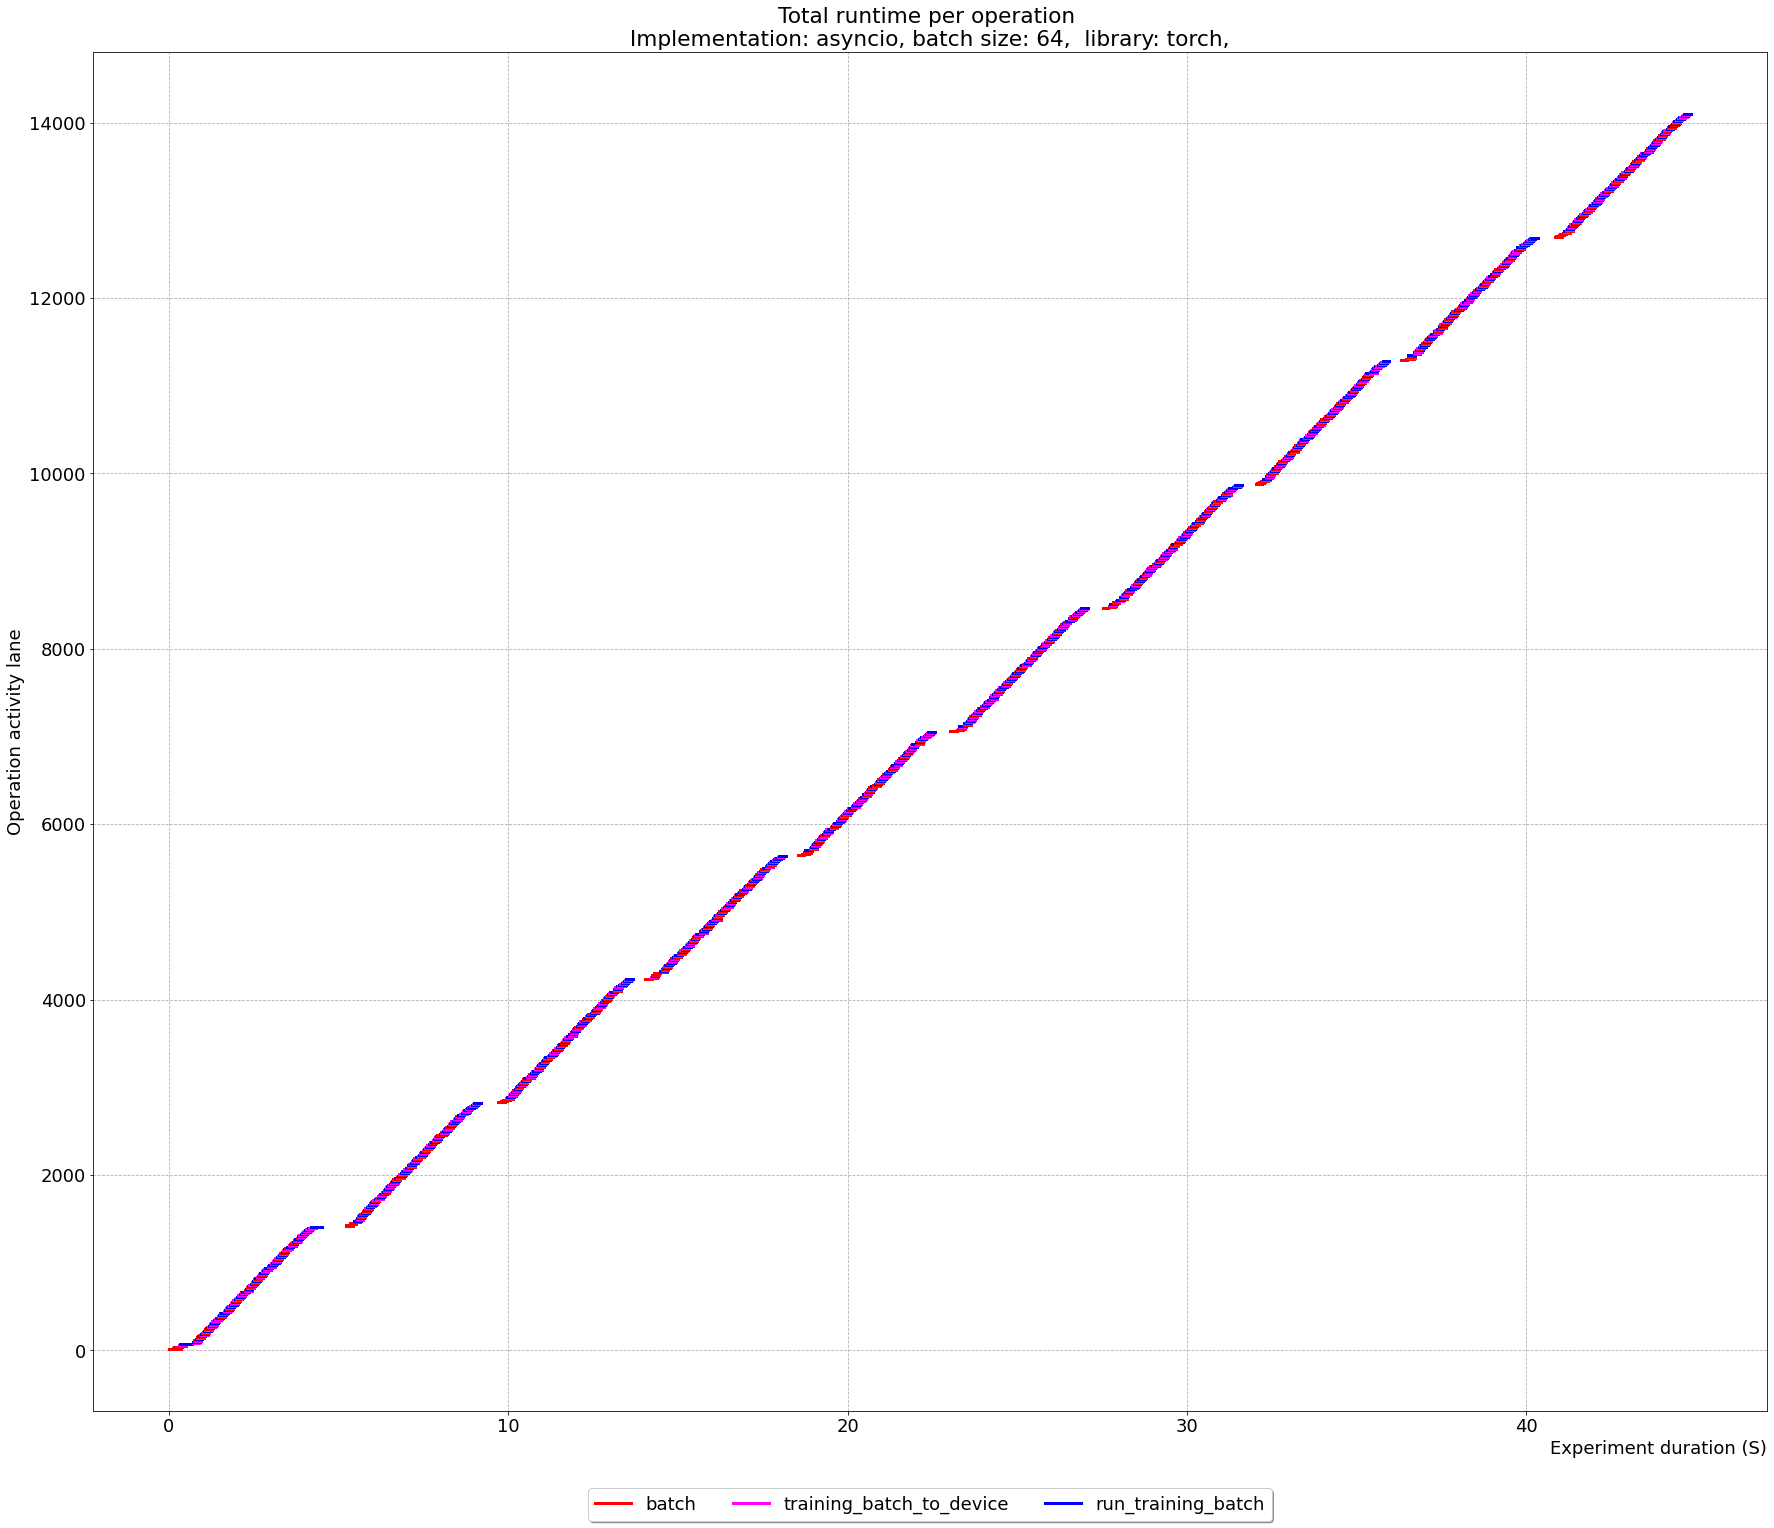

timestamp False


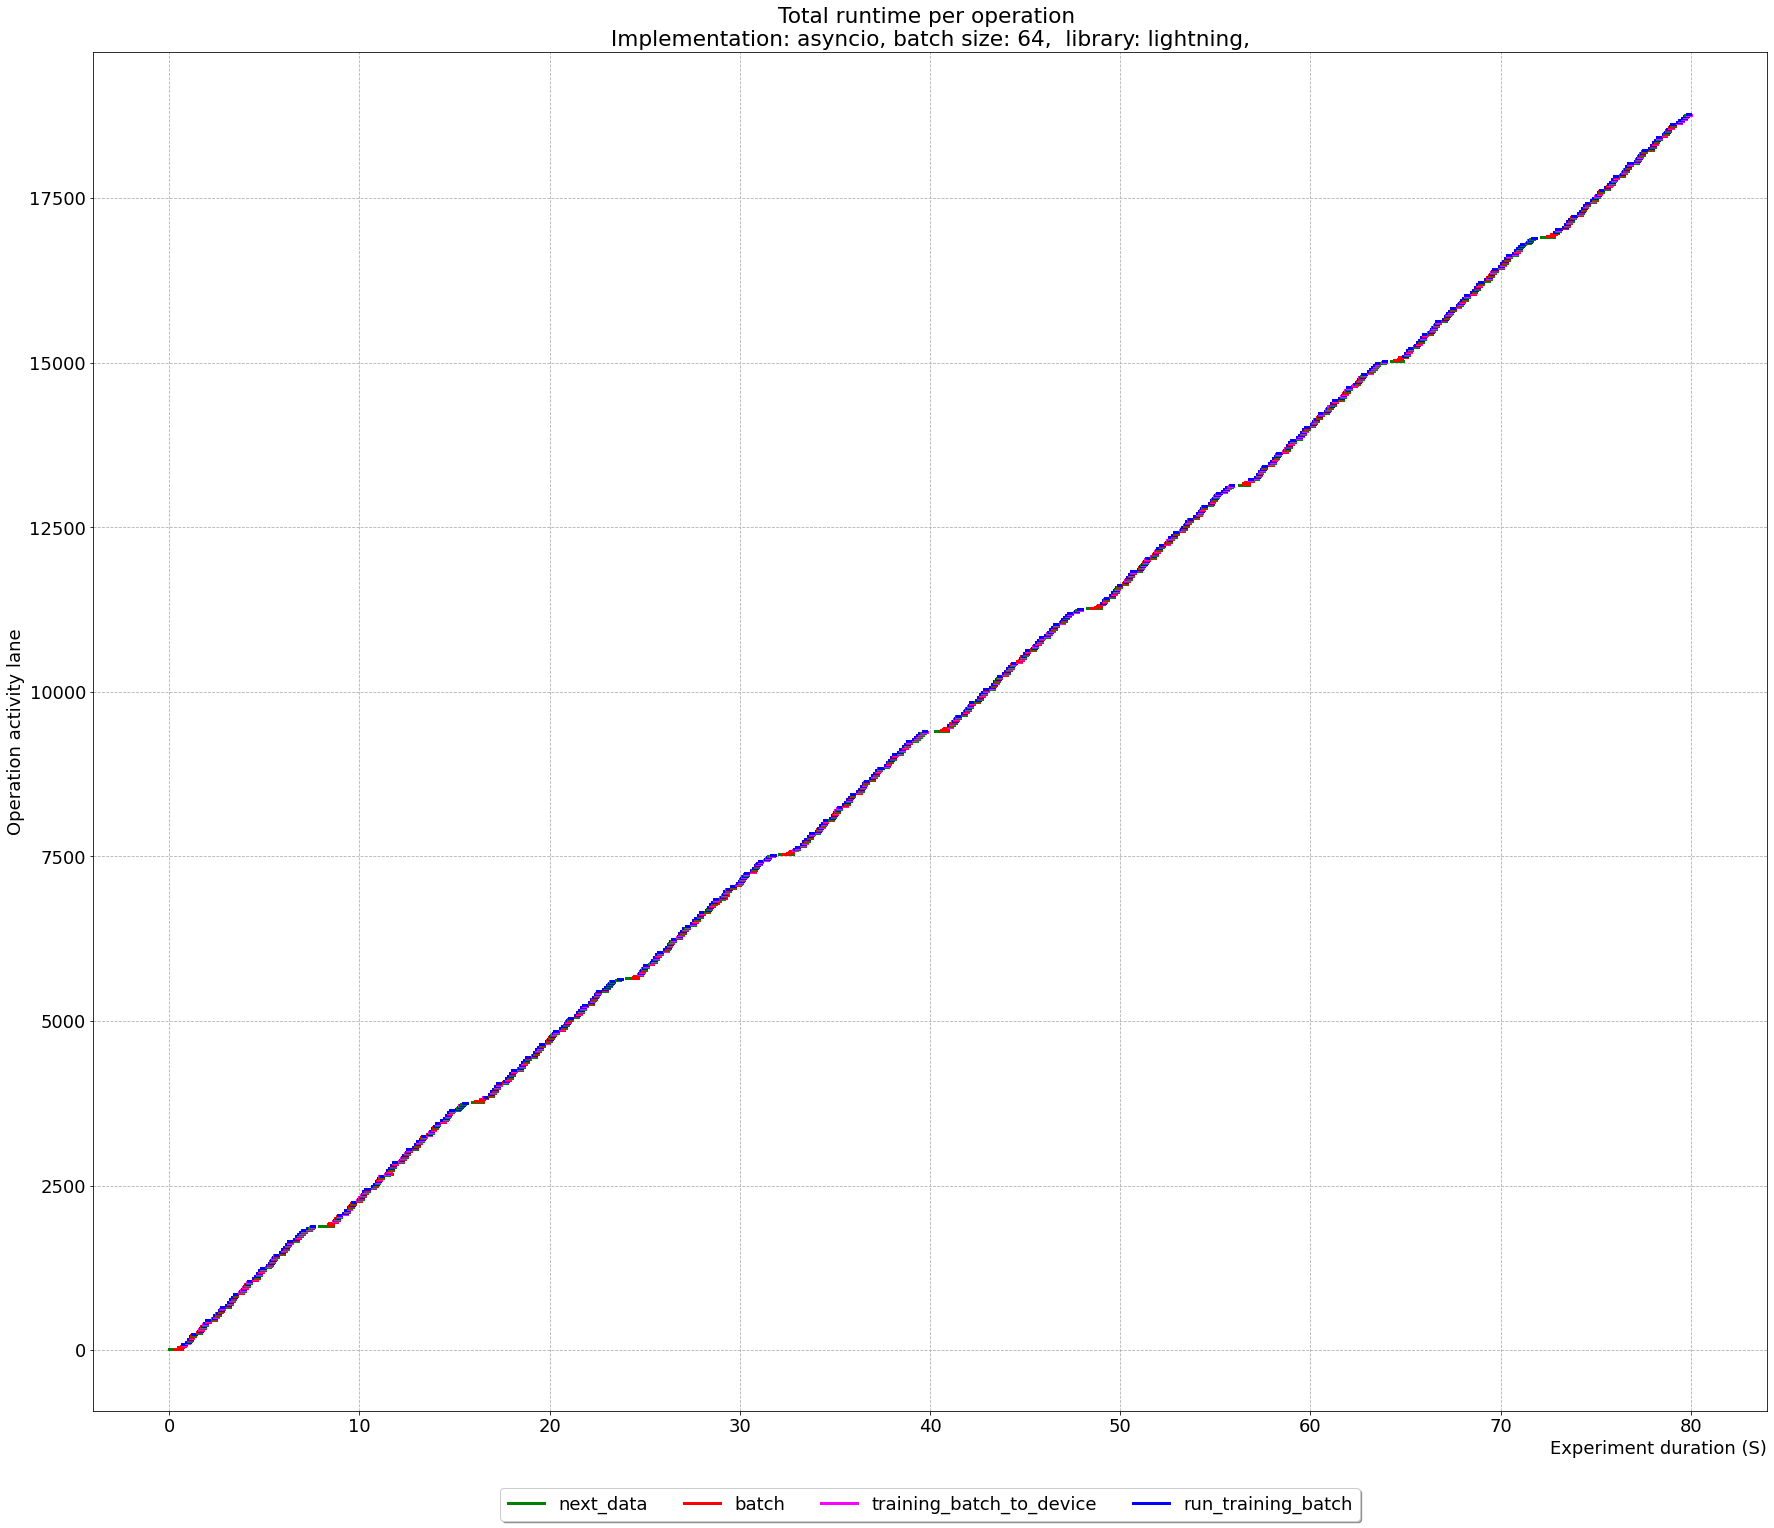

In [6]:
unique_runs_scratch, unique_functions, colors, lanes = get_colors_runs_and_lanes(df_dataloader_scratch)
returns_scratch = []

for implementation in ["torch", "lightning"]:
    for run in sorted(unique_runs_scratch):
        if implementation in run:
            df = df_dataloader_scratch[df_dataloader_scratch["run"]==run]
            dfgpu = df_gpuutil_scratch[df_gpuutil_scratch["run"]==run]
            df = df.drop_duplicates(subset="id", keep="first", inplace=False)
            result = show_timelines_with_gpu(df, dfgpu, lanes, colors, run, False, False, False, 2)
            result["run"]=run
            returns_scratch.append(result)

### GPU Utilization

In [7]:
print(unique_runs_s3, unique_runs_scratch)

['20211119f160128_benchmark_e2e_torch_s3_64_4_16_0_asyncio_sync'
 '20211119f160529_benchmark_e2e_lightning_s3_64_4_16_0_asyncio_sync'] ['20211119f160931_benchmark_e2e_torch_scratch_64_4_16_0_asyncio_sync'
 '20211119f161025_benchmark_e2e_lightning_scratch_64_4_16_0_asyncio_sync']


timestamp False
39.64150943396226 25.08


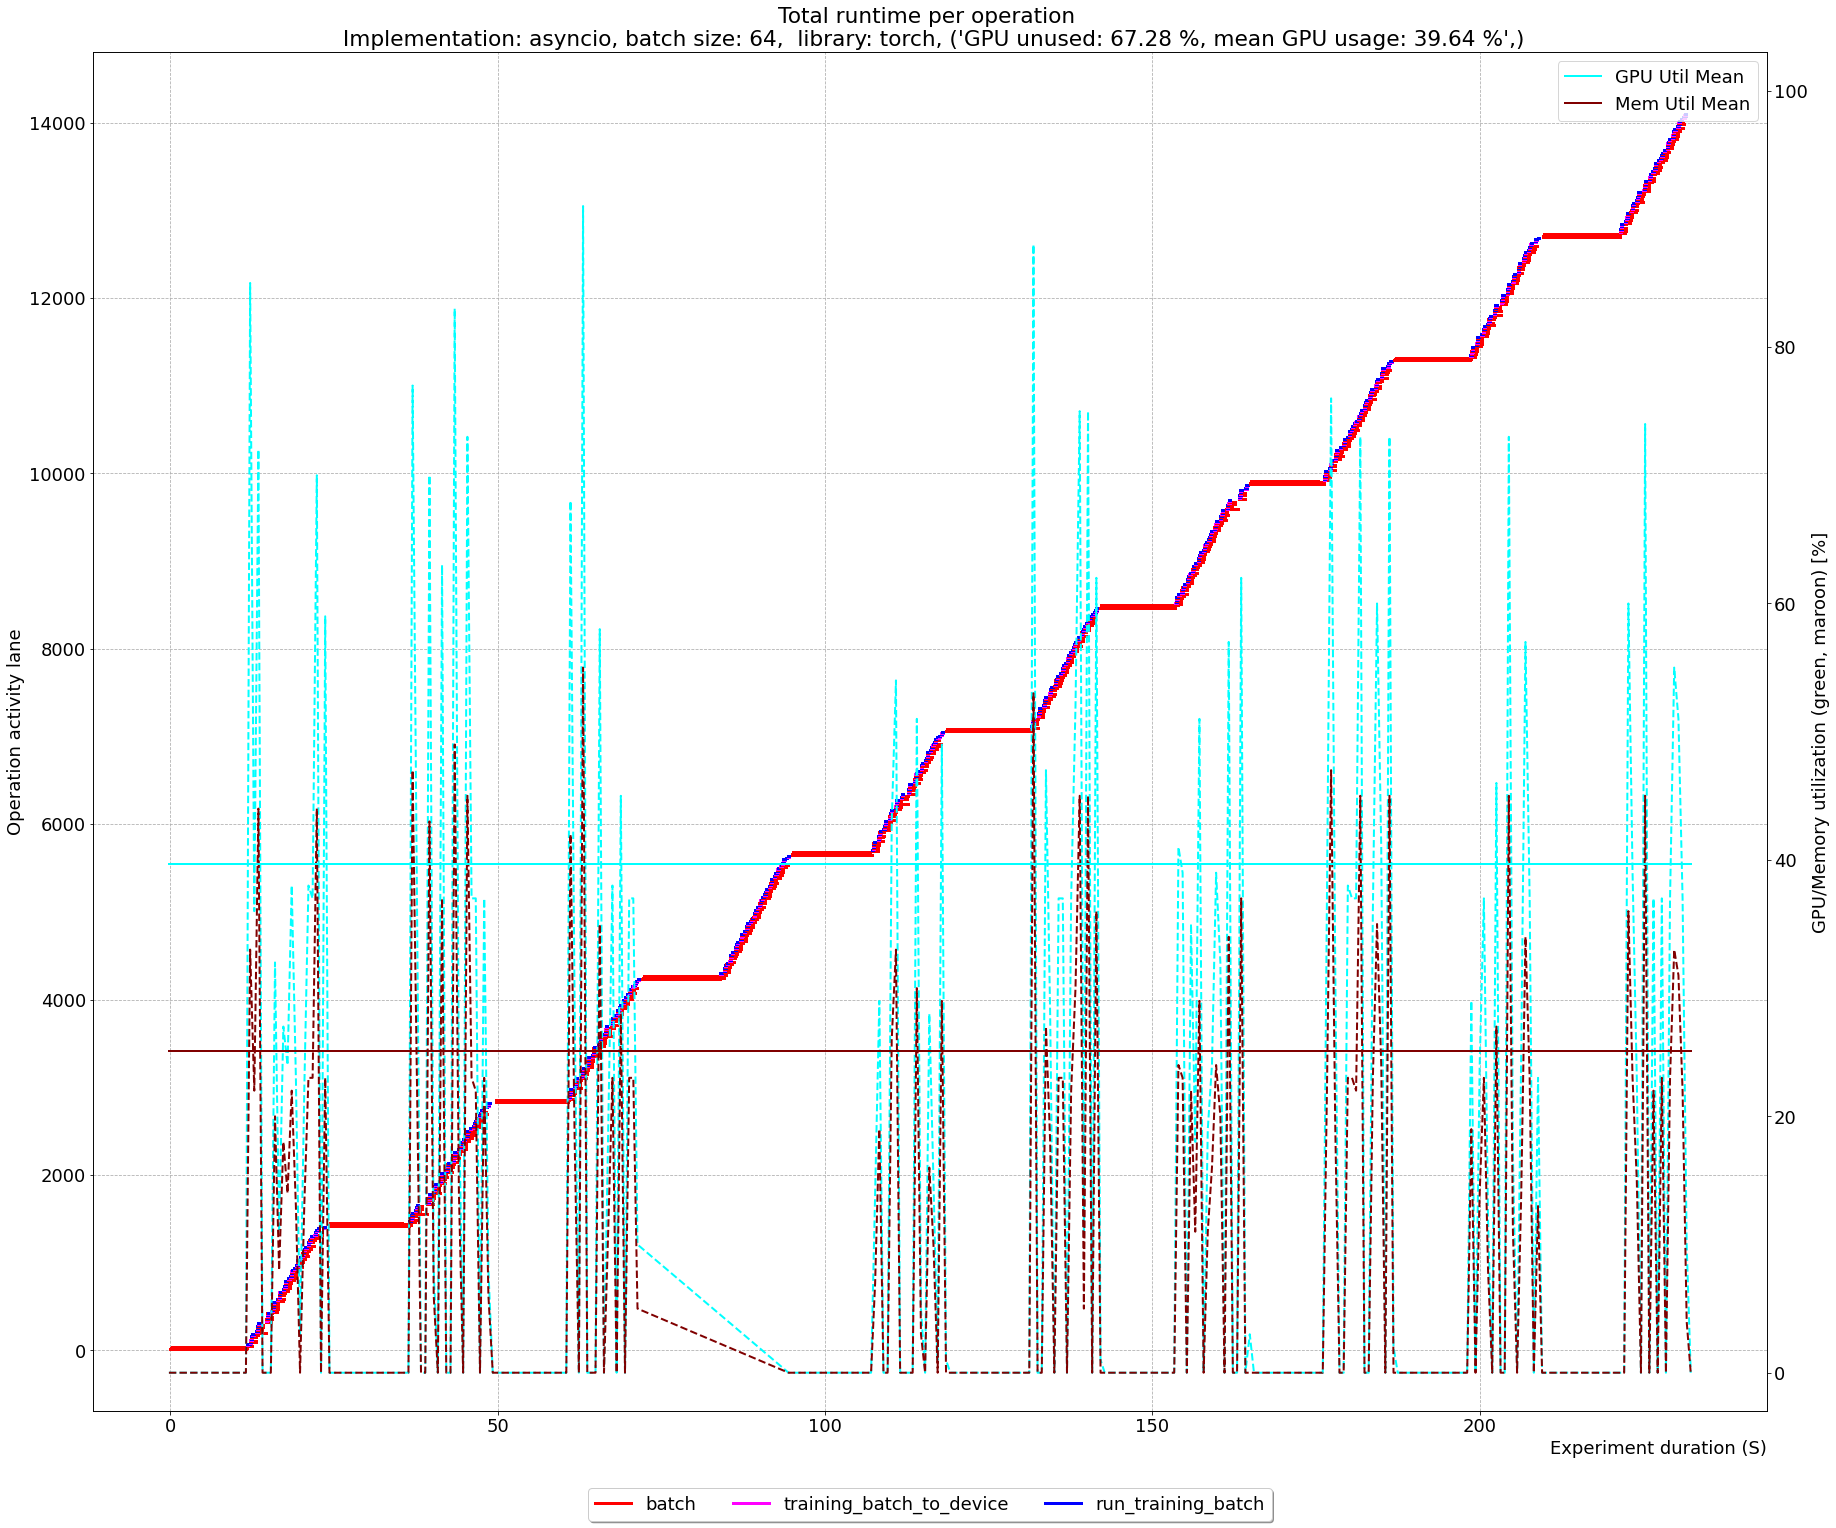

timestamp False
30.643356643356643 12.157894736842104


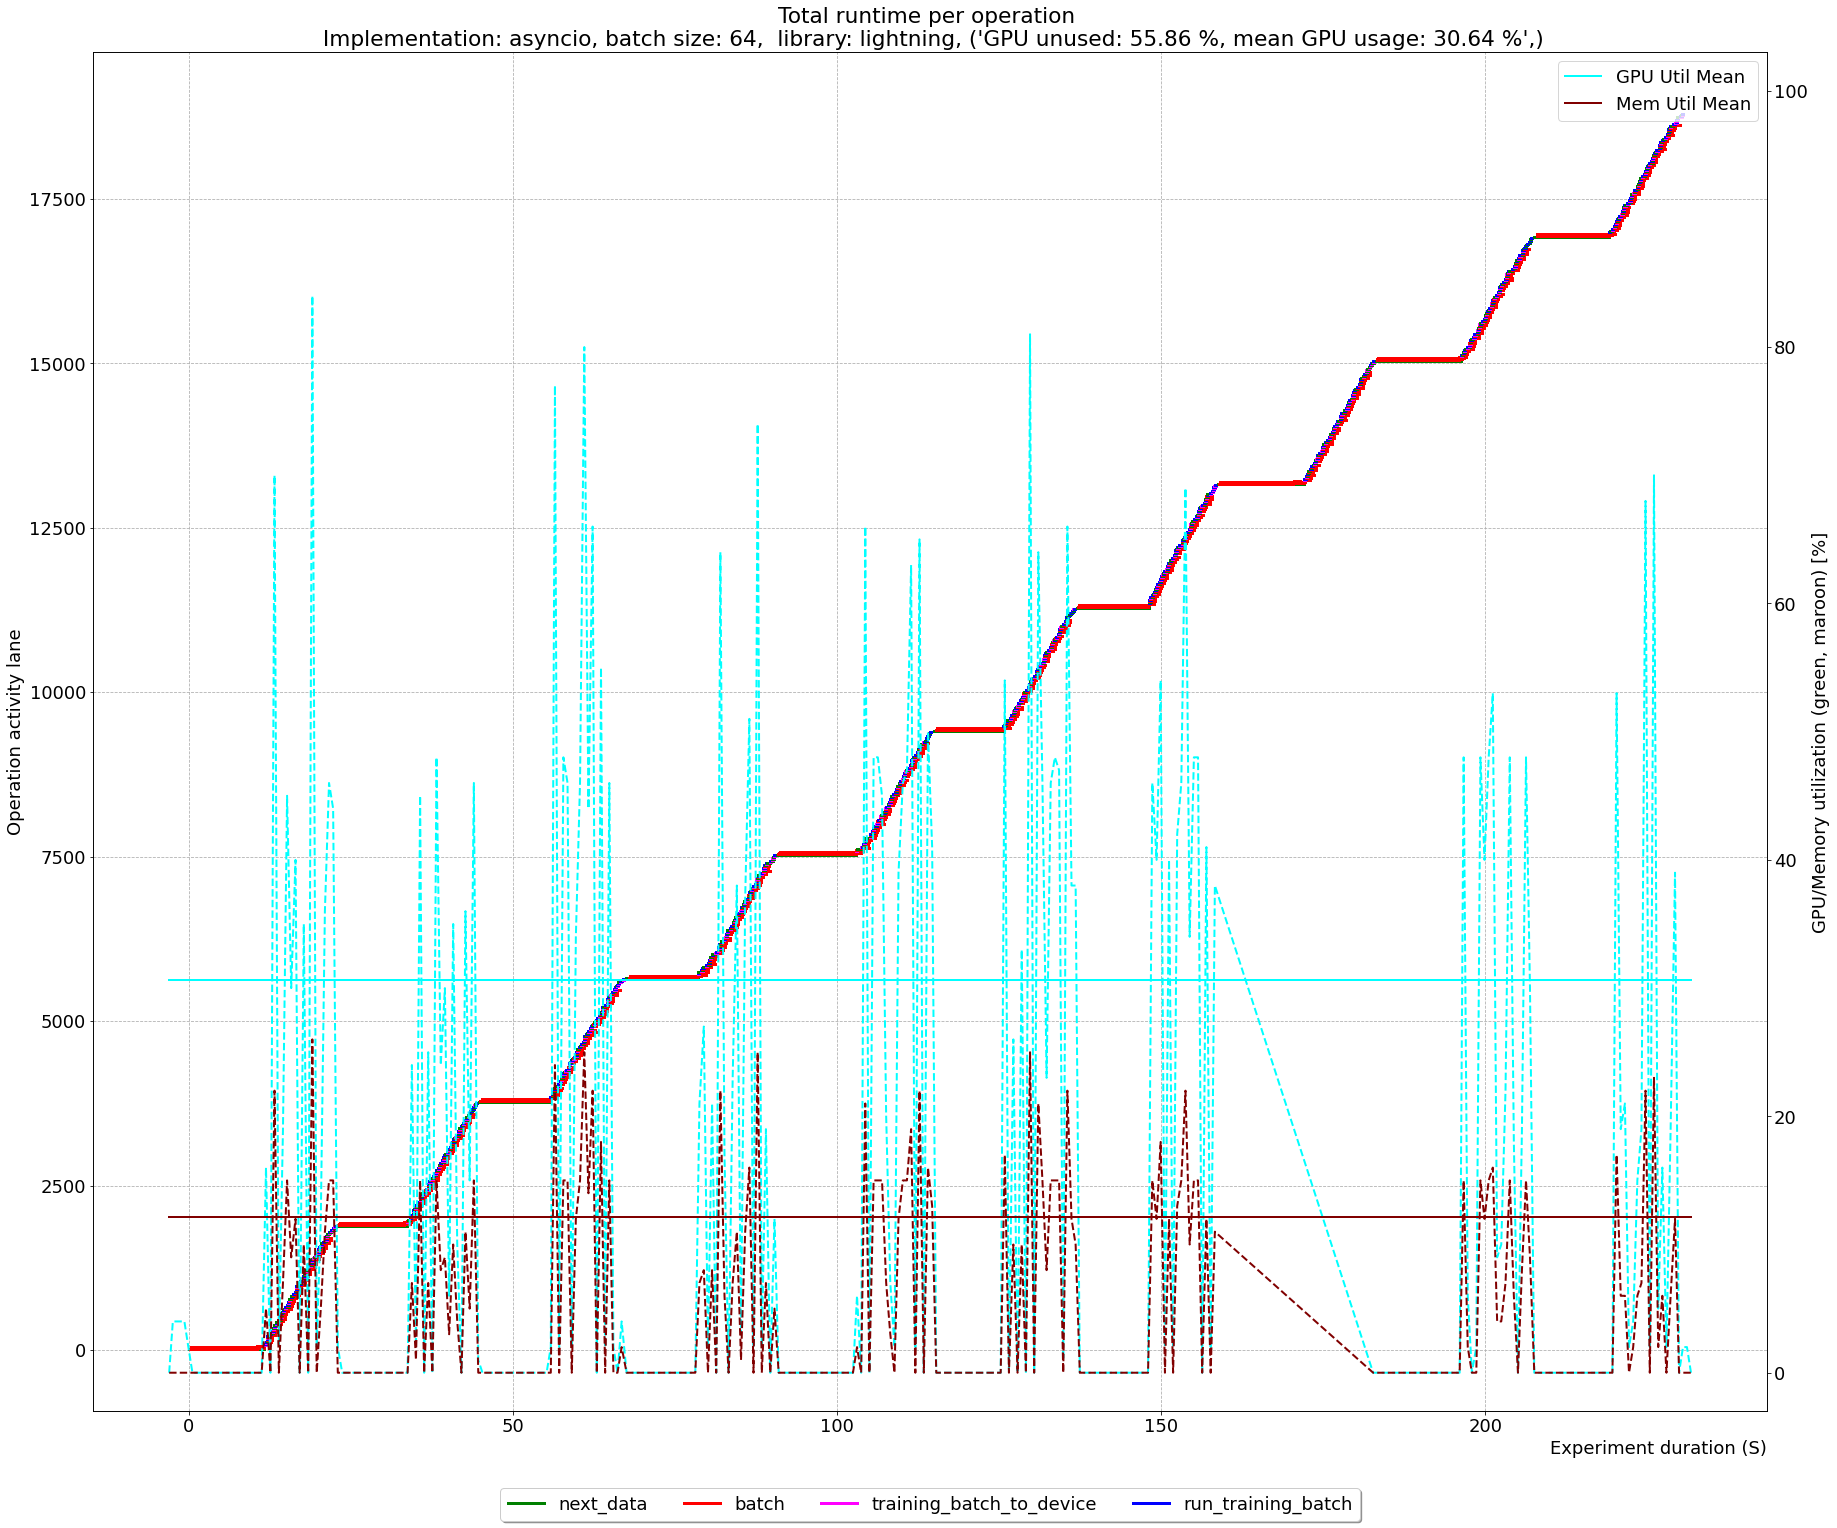

In [9]:
unique_runs_s3, unique_functions, colors, lanes = get_colors_runs_and_lanes(df_dataloader_s3)
returns_s3 = []

for implementation in ["torch", "lightning"]:
    for run in sorted(unique_runs_s3):
        if implementation in run:
            df = df_dataloader_s3[df_dataloader_s3["run"]==run]
            dfgpu = df_gpuutil_s3[df_gpuutil_s3["run"]==run]
            df = df.drop_duplicates(subset="id", keep="first", inplace=False) 
            result = show_timelines_with_gpu(df, dfgpu, lanes, colors, run, False, True, False, 2, ms=False)
            result["run"]=run
            returns_s3.append(result)

timestamp False
62.30769230769231 39.271186440677965


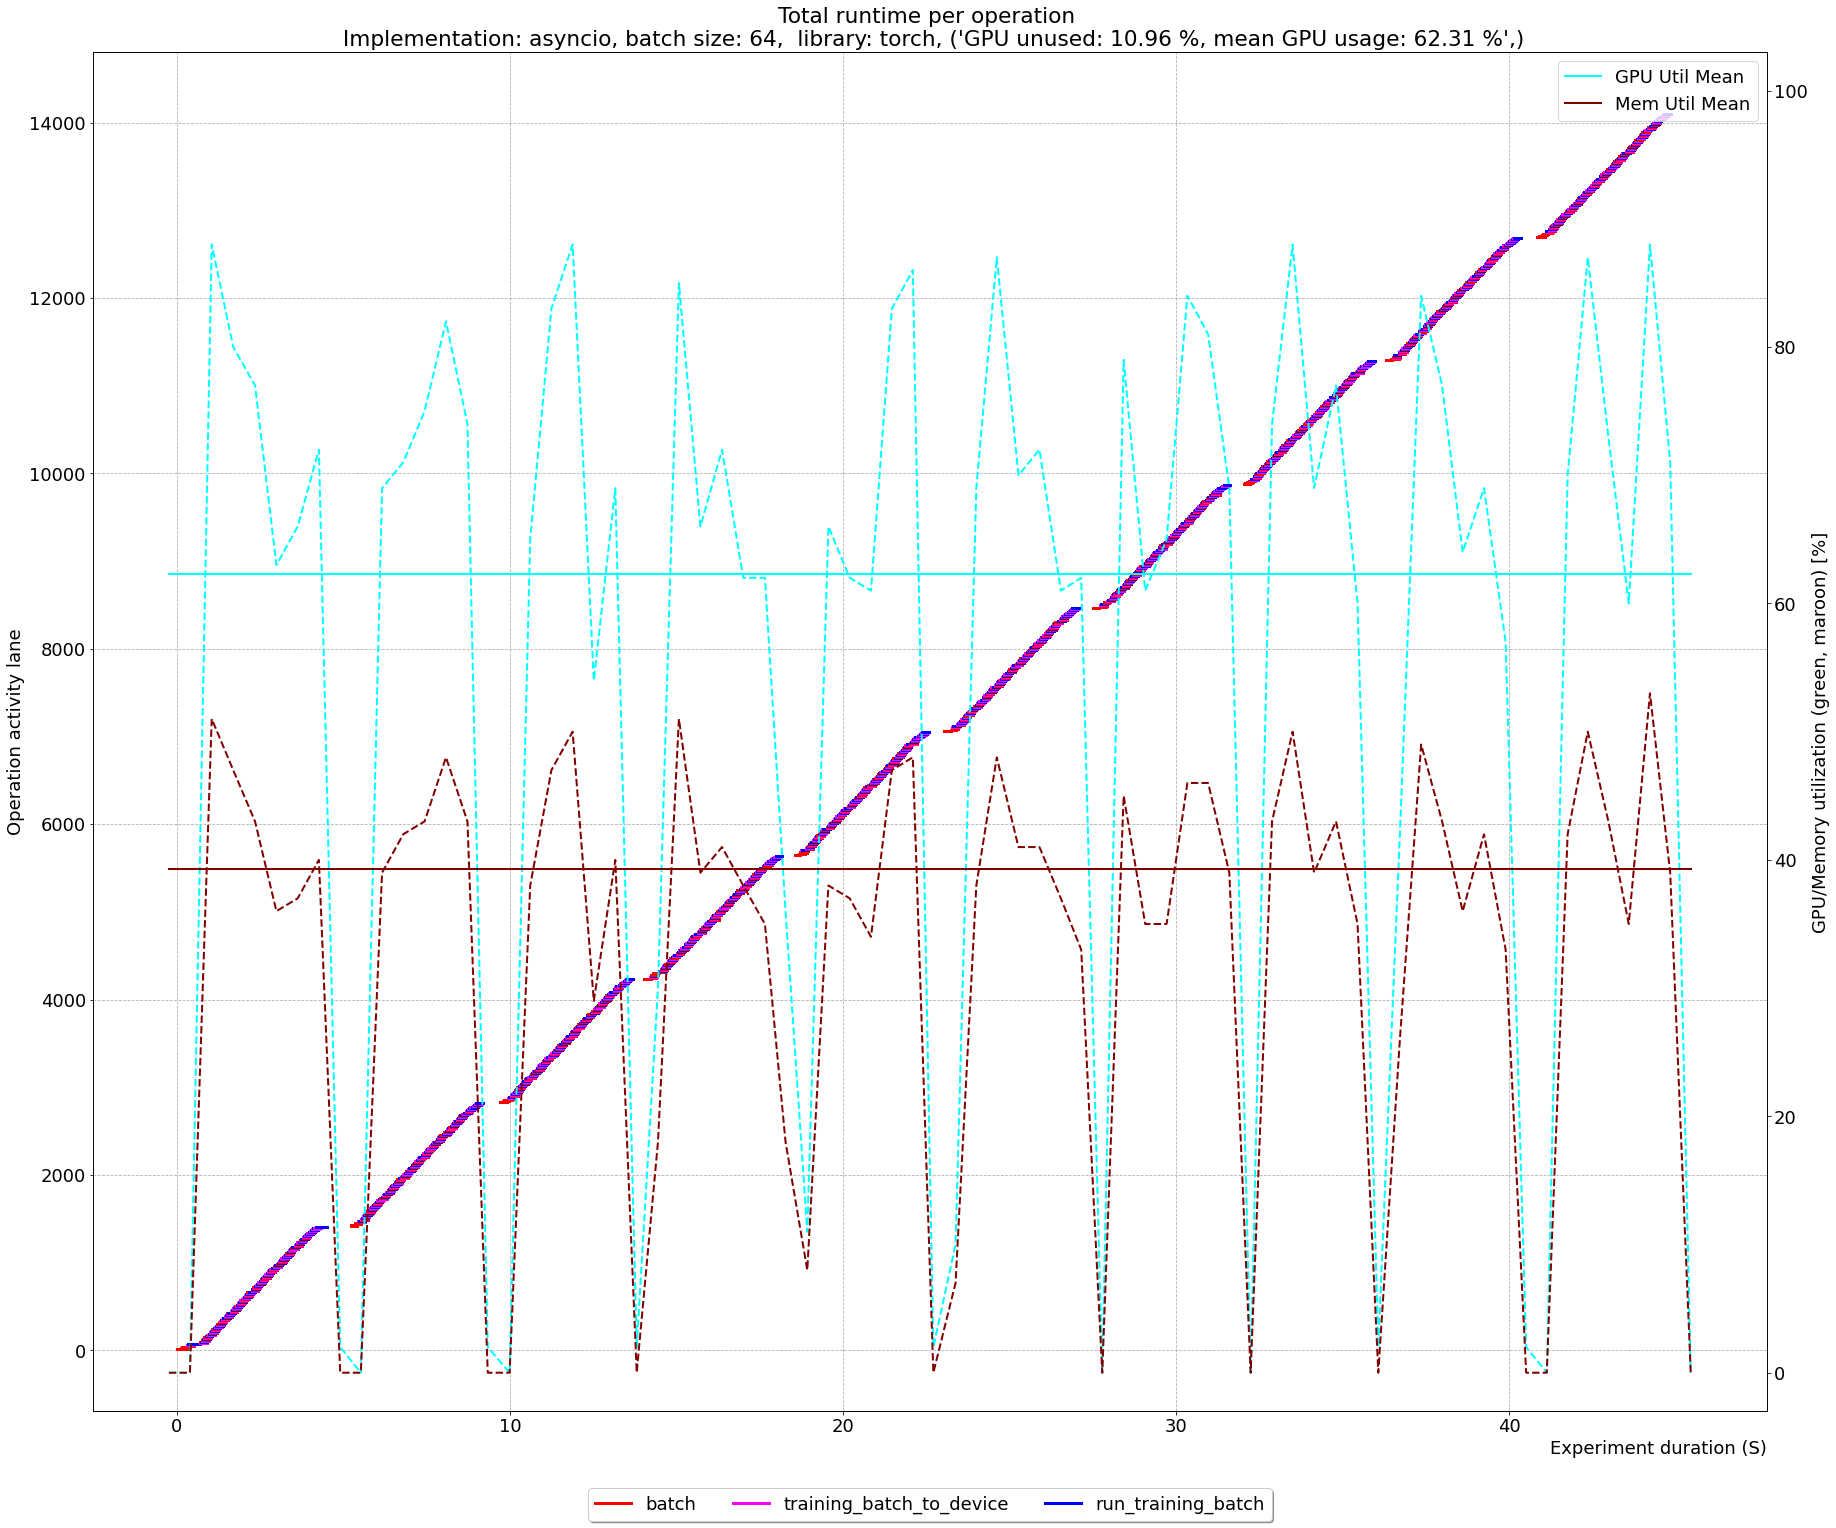

timestamp False
46.66942148760331 15.692982456140351


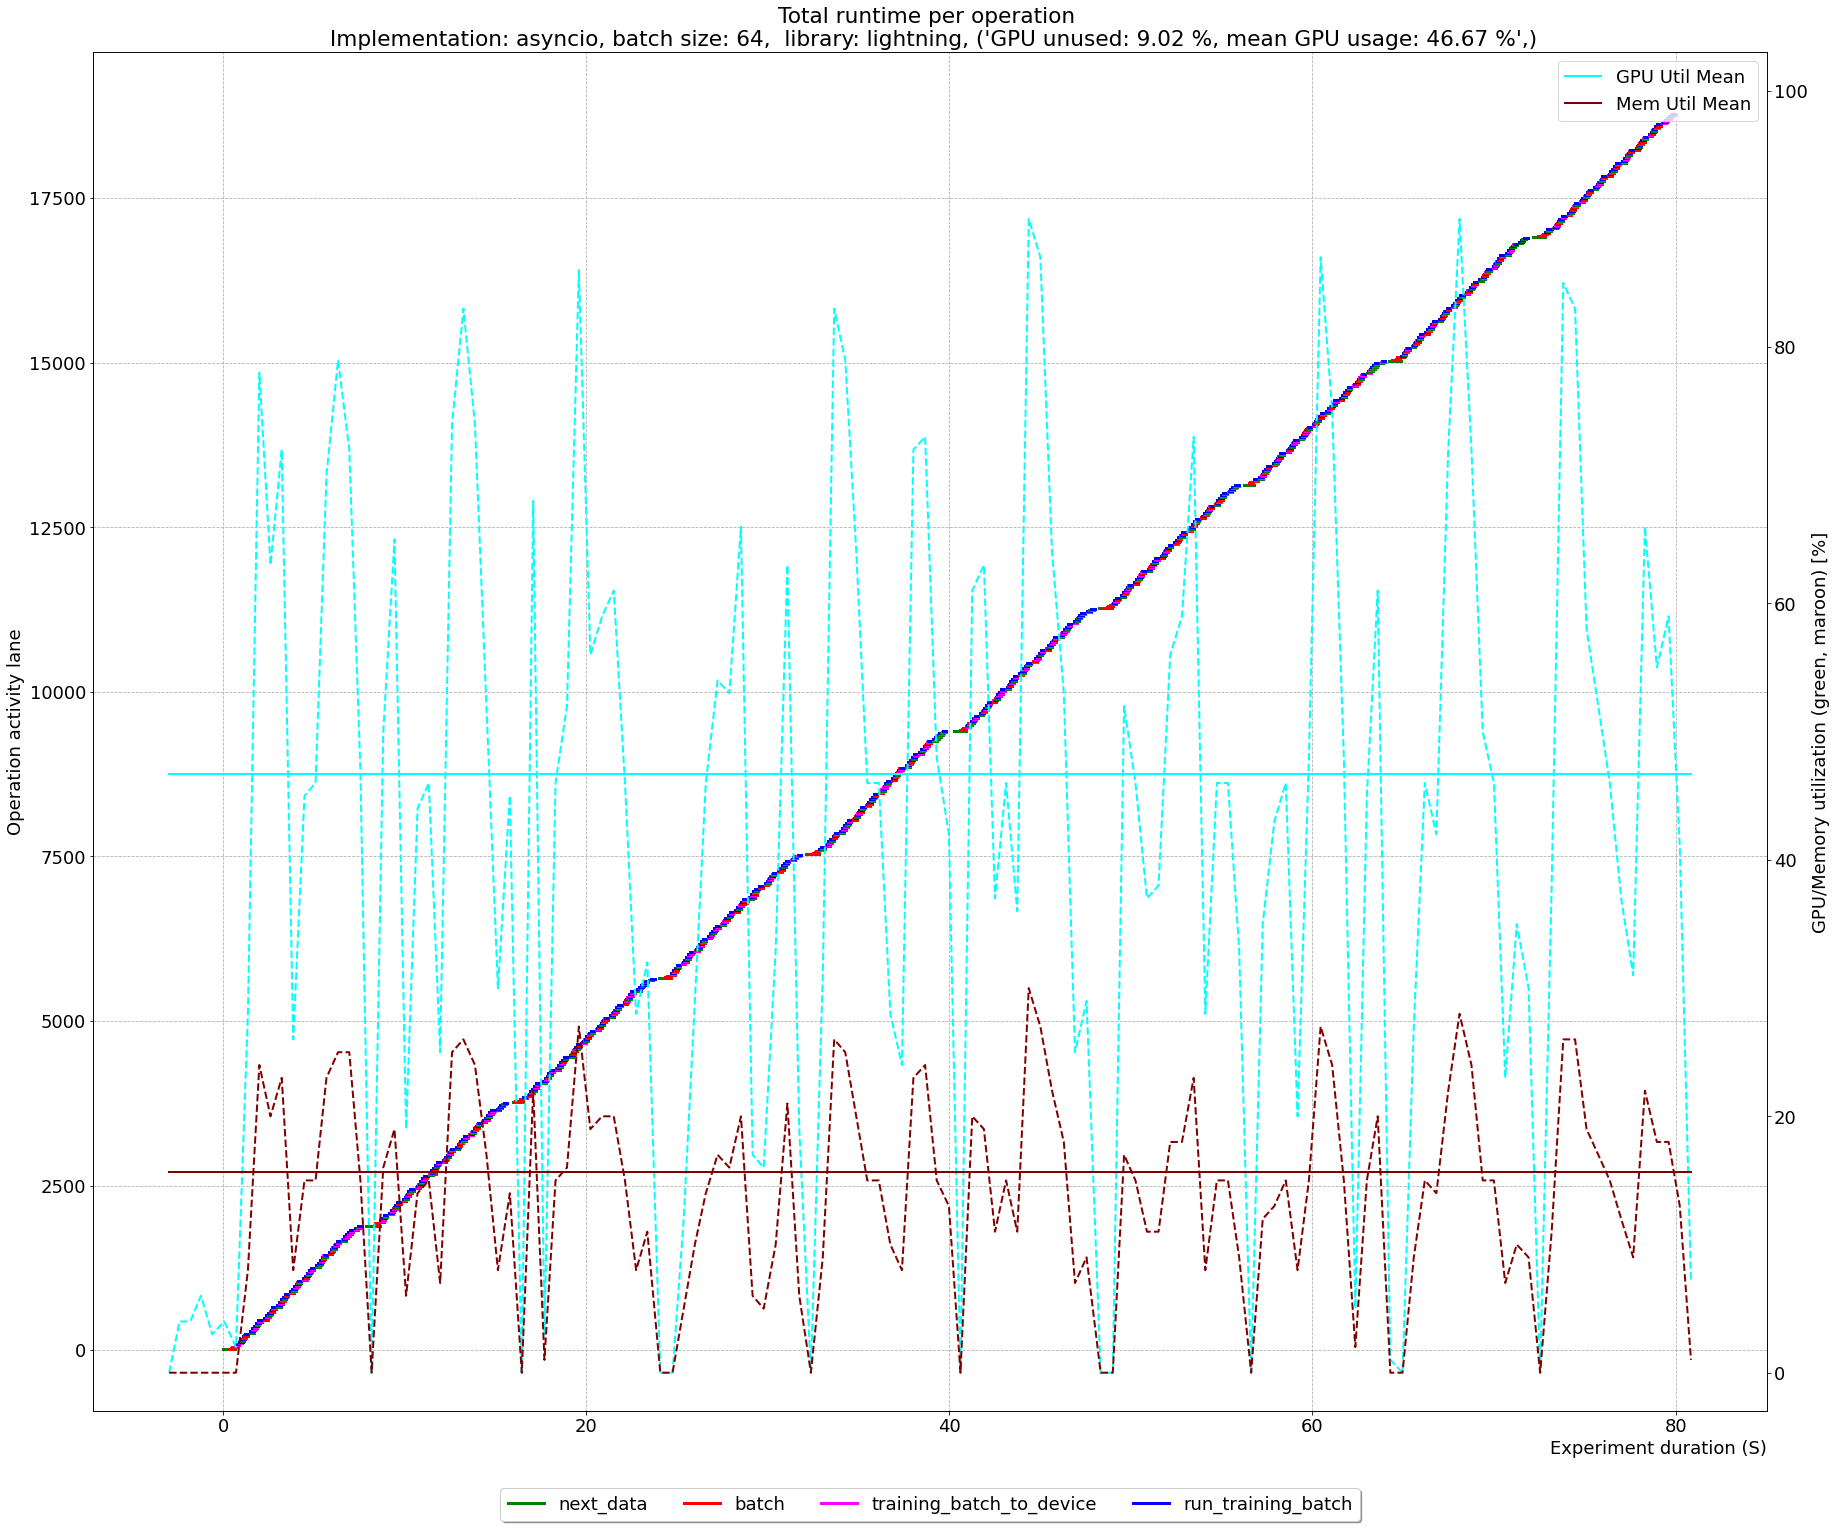

In [10]:
unique_runs_scratch, unique_functions, colors, lanes = get_colors_runs_and_lanes(df_dataloader_scratch)
returns_scratch = []

for implementation in ["torch", "lightning"]:
    for run in sorted(unique_runs_scratch):
        if implementation in run:
            df = df_dataloader_scratch[df_dataloader_scratch["run"]==run]
            dfgpu = df_gpuutil_scratch[df_gpuutil_scratch["run"]==run]
            df = df.drop_duplicates(subset="id", keep="first", inplace=False)
            result = show_timelines_with_gpu(df, dfgpu, lanes, colors, run, False, True, False, 2, ms=False)
            result["run"]=run
            returns_scratch.append(result)

### Result tables

The following two tables display throughput details for both experiments. The default sample size, i.e. number of dataset items is 3000.

In [11]:
# sanity check
get_metadata_info(output_base_folder / "1711-fork/s3" / unique_runs_s3[0])

Dataset:  3000
Batch size: 64
Epochs:  10
Images total:  30000
Batches per epoch 47
Images total (rounded):  30080


(3000, 64, 10, 30000, 47, 30080)

In [12]:
df_full_s3 = extract_pandas(output_base_folder, folder_filter=s3_folder_filter)
results_s3 = pd.DataFrame.from_records(data=returns_s3)
r = get_throughput(results_s3, "1711-fork/s3", df_full_s3, unique_runs_s3, output_base_folder)
r.round(2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 24.39it/s]


,runtime,gpu_util_zero,gpu_util_mean_no_zeros,mem_util_mean,mem_util_mean_no_zeros,implementation,cache,library,fig,throughput,dl_MB,imgs,Mbit/s,MB/s
0,231.32,67.28,39.64,7.74,25.08,asyncio,0,torch,Figure(2160x1800),129.69,3110.65,30000,107.58,13.45
1,230.50,55.86,30.64,4.28,12.16,asyncio,0,lightning,Figure(2160x1800),130.15,3110.65,30000,107.96,13.50


In [13]:
df_full_scratch = extract_pandas(output_base_folder, folder_filter=scratch_folder_filter)
results_scratch = pd.DataFrame.from_records(data=returns_scratch)
r = get_throughput(results_scratch, "1711-fork/scratch", df_full_scratch, unique_runs_scratch, output_base_folder)
r.round(2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:03<00:00, 23.50it/s]


,runtime,gpu_util_zero,gpu_util_mean_no_zeros,mem_util_mean,mem_util_mean_no_zeros,implementation,cache,library,fig,throughput,dl_MB,imgs,Mbit/s,MB/s
0,44.67,10.96,62.31,31.74,39.27,asyncio,0,torch,Figure(2160x1800),671.55,2857.1,30000,511.65,63.96
1,79.98,9.02,46.67,13.45,15.69,asyncio,0,lightning,Figure(2160x1800),375.08,2857.1,30000,285.77,35.72
